# EDA for the OTTO – Multi-Objective Recommender System

# Content
1. Intro
2. Setup
3. Import of json and parquet files
4. Shape of Datasets and features
5. Exploring and plotting
6. Cleaning?!

## 1. Intro

Link to Competition: https://www.kaggle.com/competitions/otto-recommender-system/overview

"Goal of the Competition

The goal of this competition is to predict e-commerce clicks, cart additions, and orders. You'll build a multi-objective recommender system based on previous events in a user session.

Your work will help improve the shopping experience for everyone involved. Customers will receive more tailored recommendations while online retailers may increase their sales."


### In this notebook we will explore the given dataset. Partly working with a fraction of the data to make it manageable.
### Given the existing sessions we want to predict the clicks (CTR), add to card and orders (conversion).


## 2. Setup

In [1]:
### Imports ###

import pandas as pd
import numpy as np
import polars as pl

from pathlib import Path
import os
import random
import json
from datetime import timedelta
from collections import Counter
from heapq import nlargest

from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

## 3. Import of json and parquet files

The otto challenge data is given as a json file. Here: https://www.kaggle.com/competitions/otto-recommender-system/data

For faster processing, the json files can be converted to parquet files with the EDA_0_jason_to_parquet notebook (execution takes longer) 
or downloaded here: https://www.kaggle.com/datasets/radek1/otto-full-optimized-memory-footprint

In [2]:
### importing the json files ###
#train_j = pd.read_json('../data/train.jsonl', lines=True) # takes much time
#test_j = pd.read_json('../data/test.jsonl', lines=True) # not used now

In [3]:
### Counting train dataset without loading ###

with open('../data/train.jsonl', 'r') as f:
    print(f"There are {len(f.readlines()):,} lines in the training data")

# There are 12,899,779 lines in the training data

There are 12,899,779 lines in the training data


In [4]:
### importing only 150.000 lines of the training data ###

sample_size = 150000

chunks = pd.read_json('../data/train.jsonl', lines=True, chunksize = sample_size)

for c in chunks:
    train_j_df = c
    break

In [5]:
### setting index for the ###
train_j_df.set_index('session', drop=True, inplace=True)
train_j_df.head(5)

,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [6]:
### importing the parquet files ###
train_p = pl.read_parquet('../data/train.parquet')
test_p = pl.read_parquet('../data/test.parquet')

## 4. Shape of datasets and features

- json train: 12,899,779 lines
- parquet train unpacked with every aid in a own line 216,716,096

In [7]:
### shapes of json ###
train_j_df.shape
#test_j.shape



(150000, 1)

In [8]:
### shapes of parquet ###
print(train_p.shape)
print(test_p.shape)

(216716096, 4)
(6928123, 4)


In [9]:
train_p.head()

session,aid,ts,type
i32,i32,i32,u8
0,1517085,1659304800,0
0,1563459,1659304904,0
0,1309446,1659367439,0
0,16246,1659367719,0
0,1781822,1659367871,0


In [10]:
### unique sessions and article ids ###
print(train_p['session'].n_unique())
print(train_p['aid'].n_unique())

12899779
1855603


In [11]:
### click 0, add to cart 1 and order is 2 ###
train_p['type'].unique()

type
u8
0
1
2


In [12]:
### selecting different sessions with specific features ###
q = (
    train_p.lazy()
    .groupby("session")
    .agg(
        [
            (pl.col("type") == 0).sum().alias("click"),
            (pl.col("type") == 1).sum().alias("cart"),
            (pl.col("type") == 2).sum().alias("order"),
        ]
    )
    .sort("click", reverse=False)
    
)

train_p1 = q.collect()

In [13]:
train_p1.head(5)

session,click,cart,order
i32,u32,u32,u32
10485760,2,0,0
2097152,2,1,0
7711160,2,0,0
9130864,2,0,0
2839408,2,0,0


## 5. Exploring and plotting

### 150.000 json dataset train_j_df converted to dataframe

In [23]:
train_j_df = train_j_df.reset_index() #adding index
train_j_df.head #control

<bound method NDFrame.head of          index  session                                             events
0            0        0  [{'aid': 1517085, 'ts': 1659304800025, 'type':...
1            1        1  [{'aid': 424964, 'ts': 1659304800025, 'type': ...
2            2        2  [{'aid': 763743, 'ts': 1659304800038, 'type': ...
3            3        3  [{'aid': 1425967, 'ts': 1659304800095, 'type':...
4            4        4  [{'aid': 613619, 'ts': 1659304800119, 'type': ...
...        ...      ...                                                ...
149995  149995   149995  [{'aid': 443027, 'ts': 1659332465408, 'type': ...
149996  149996   149996  [{'aid': 1849006, 'ts': 1659332465484, 'type':...
149997  149997   149997  [{'aid': 135905, 'ts': 1659332465575, 'type': ...
149998  149998   149998  [{'aid': 288928, 'ts': 1659332465804, 'type': ...
149999  149999   149999  [{'aid': 1752139, 'ts': 1659332465811, 'type':...

[150000 rows x 3 columns]>

In [19]:
### json to df and from 150,000 to 7 million... ###
events_dict = {
    "session": [],
    "aid": [],
    "ts": [],
    "type": [],
}

for _, row in train_j_df.iterrows():
    for event in row["events"]:
        events_dict["session"].append(row["session"])
        events_dict["aid"].append(event["aid"])
        events_dict["ts"].append(event["ts"])
        events_dict["type"].append(event["type"])

train_part = pd.DataFrame(events_dict)
train_part

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
7841822,149998,752186,1659332590213,clicks
7841823,149999,1752139,1659332465811,clicks
7841824,149999,276163,1659332518642,clicks
7841825,149999,1617030,1660131815785,clicks


In [20]:
### changing the time ###
train_part['ts'] = pd.to_datetime(train_part['ts'], unit='ms')
display(train_part)

,session,aid,ts,type
0,0,1517085,2022-07-31 22:00:00.025,clicks
1,0,1563459,2022-07-31 22:01:44.511,clicks
2,0,1309446,2022-08-01 15:23:59.426,clicks
3,0,16246,2022-08-01 15:28:39.997,clicks
4,0,1781822,2022-08-01 15:31:11.344,clicks
...,...,...,...,...
7841822,149998,752186,2022-08-01 05:43:10.213,clicks
7841823,149999,1752139,2022-08-01 05:41:05.811,clicks
7841824,149999,276163,2022-08-01 05:41:58.642,clicks
7841825,149999,1617030,2022-08-10 11:43:35.785,clicks


In [21]:
### stats of the dataset ###
n_sessions = train_part["session"].nunique()
n_events = train_part.shape[0]

print(f"Number of sessions: {n_sessions}")
print(f"Number of events: {n_events}")
print(f"Mean number of events in session: {n_events/n_sessions}")

Number of sessions: 150000
Number of events: 7841827
Mean number of events in session: 52.27884666666667


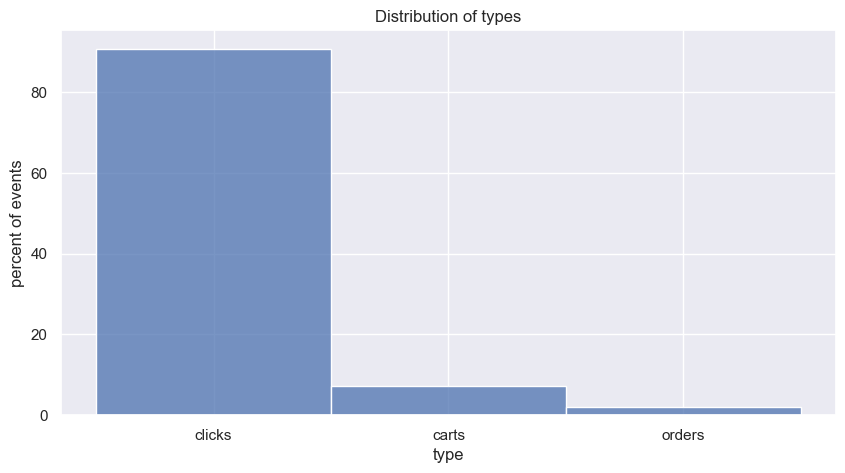

In [26]:
#sns.color_palette("rocket", as_cmap=True)

plt.figure(figsize=(10, 5))
sns.histplot(train_part['type'], stat='percent', kde=False, bins=100, palette="rocket")
plt.title('Distribution of types')
plt.xlabel('type')
plt.ylabel('percent of events')
plt.show()

Renaming with polar

In [ ]:
df1= train_p.clone()

In [ ]:
from_ = [0, 1, 2]
to_ = ['click', 'cart', 'order']

In [ ]:
df1= df1.with_column(
    pl.when(pl.col("type") == from_[0])
    .then(to_[0])
    .when(pl.col("type") == from_[1])
    .then(to_[1])
    .when(pl.col("type") == from_[2])
    .then(to_[2])
    .otherwise(pl.col("type")).alias("type")
)

df1['type'].unique()

## 6. Cleaning?

Notebook Inspiration:

https://www.kaggle.com/code/edwardcrookenden/otto-getting-started-eda-baseline

https://www.kaggle.com/code/parthpankajtiwary/otto-eda-understanding-users-and-events

https://www.kaggle.com/code/mvvppp/otto-eda-to-getting-started